# User experiments

We design the experiments based on the recommendations from the data analysis. And then when the data from the implementation comes back, we interpret it and give an insight.

So input is testing recommendations, and output is insights.

We're going to do two types of tests: traditional user testing which is realistic for this restaurant, and A/B testing which is rare in restaurants but not impossible.

### A note on A/B testing

A/B testing is a specific type of user testing that involves one population two versions of something at the same time. This is different than traditional user testing where a restaurant might make a change for a month and see if the results are better or worse than expected. 

Because of this, A/B testing is usually used on software products, or in cases where there are large samples AND you can easily show two versions of a product. The closest you can probably get in a restaurant is giving half of a restaurant one menu and another half a different menu (you would be worried about logistics and having a large enough sample size or enough past data), or having two identical restaurants in areas with populations with comparable tastes (e.g. a McDonalds in two parts of the same city - you would still want enough historical data to be able to tell the two apart though). 

We're generating data, so it's possible for us to simulate situations that are otherwise impossible, like the same restaurant changing hours but only for 50% of the population. I'll use this to A/B test different menus (which would be possible but logistically challenging). 

# A/B test suggestions

We got some suggestions from the data_analysis notebook. We'll take a closer look at how to actually test it here, and evaluate the results.

1. Change weekdays?
2. Change items offered (combos?)
3. Change menu?

We really only need to test things we're not sure about or that we want to really optimize.

Menu change is a free a/b test - usually you'd want to split the test with the same population but that's logistically a lot to ask for a real-time business like a restaurant. But we do have a lot of past data, so we just try the new menu for a month and see if it performs outside of a confidence interval.

In the next notebook, we'll do analysis and assume we have no knowledge of this generator. We will approach it like a real, independent dataset.

# Experiment 1: changing hours. What happens if we have the restaurant open on mondays instead?

### Hypotheses

Null: Staying open on Wednesdays and not Mondays is better for sales.

Alternate: Opening on Mondays instead of Wednesdays is better for sales. (do we need a certain percentage?)

one-tailed test because i only care if it's higher or not

<!-- The percentage probably comes from how much of a hassle it is for us to be open on Mondays instead of Wednesdays. For example, if we're willing to be open on Mondays if it generates 1% more money on average, a a mean increase of 0.5% wouldn't be sufficient. It seems like most restaurants are historically closed on Mondays because sales are low (which is what we'll test), and because the weekends are really exhausting. If we see a feww 5% increase in sales just from being open on Mondays instead of Wednesdays, that seems like a good enough reason to be open on Mondays instead.

If it looks like it's going well, we can always run longer to test, but in theory you'd like to spend the time testing something else.
 -->

### Key assumptions

- I guess that there aren't any other significant market changes (*cough cough covid*), and we're not running any other experiments.
- Customers are immediately aware of the changes in hours - assume switching costs are negligible. In a real experiment we'd want to run a bit longer to account for this.
- Assume we have buy in - despite the notion that mondays tend to have less sales, the restaurant owners are willing to give it a try.

### Test runtime (how many data points do we need to know if it's significant?)

One month? We're very confident in our past data, so we probably don't need a huge sample.

We basically have 150 * 8 datapoints representing every hour of every monday for the past three years. If we run for a month, we're looking at 4 * 8 datapoints to compare. This is because we care about the number of orders per hour.

### Success metrics (how do we actually know if it's significant?)

...some percentage confidence that the mean price has actually gone up, right?

What kind of confidence do we need? The change is small so we probably want something kind of big. Maybe 90% is fine since we do have very unusually trustworthy data.

**90% confidence interval says we are 90% certain that the poplation proportion for ________ will fall between x% and y%.** <-- we set the confidence interval... think about what makes it go up and down.

==> we describe a finding as statistically significant by interpeting the p value (compare p value to threshold value chosen beforehand: significance level, which is 1 - confidence)
--> a reuslt is statistically significant when the p value is smaller than the alpha





### Run experiment

Some notes...

### Evaluate experiment

##### Check non-Monday days to make sure there aren't any changes

In [3]:
# how do i actually compare these? - just compare to the average wednesday?

import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import scipy as sp

pd.options.display.max_rows = 10  # limit huge ouputs
plt.rcParams['figure.figsize'] = (20.0, 10.0)  # set default figsize
plt.style.use('ggplot')  # plt.style.available
warnings.filterwarnings("ignore")  # filter warnings

In [4]:
# experiment data
exp_df = pd.read_csv("../thaitanic/generators/experiment_generators/mon_wed_experiment/January_2020_data_test_hours.csv").sort_values(by='Order Date', ascending=False)
exp_df.reset_index(drop=True, inplace=True)

# add sales, datetime columns to filter by
exp_df['Order Date'] = pd.to_datetime(exp_df['Order Date'])
exp_df['Sales'] = exp_df['Quantity Ordered'] * exp_df['Price Each']
exp_df['Year'] = exp_df['Order Date'].dt.year
exp_df['Month'] = exp_df['Order Date'].dt.month
exp_df['Weekday'] = exp_df['Order Date'].dt.day_name()
exp_df['Weekday Value'] = exp_df['Order Date'].dt.weekday
exp_df['Hour'] = exp_df['Order Date'].dt.hour
exp_df['Day of Month'] = exp_df['Order Date'].dt.day

exp_df

,Order ID,Item,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour,Day of Month
0,226615,Pad Kee Mao,4,12,2020-01-31 20:53:00,48,2020,1,Friday,4,20,31
1,226623,Pumpkin Curry,1,15,2020-01-31 20:50:00,15,2020,1,Friday,4,20,31
2,226628,Grilled Thai Steak,1,20,2020-01-31 20:49:00,20,2020,1,Friday,4,20,31
3,226629,Pra Ram,1,12,2020-01-31 20:38:00,12,2020,1,Friday,4,20,31
4,226633,Thai Fried Rice,1,12,2020-01-31 20:36:00,12,2020,1,Friday,4,20,31
...,...,...,...,...,...,...,...,...,...,...,...,...
6115,220858,Won Ton Soup,2,12,2020-01-02 11:09:00,24,2020,1,Thursday,3,11,2
6116,220856,Basil Fried Rice,1,12,2020-01-02 11:05:00,12,2020,1,Thursday,3,11,2
6117,220850,Yum Nua,1,12,2020-01-02 11:02:00,12,2020,1,Thursday,3,11,2
6118,220853,Pad See Ew,1,12,2020-01-02 11:00:00,12,2020,1,Thursday,3,11,2


In [5]:
# all previous data
df = pd.read_csv("../thaitanic/data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)

# add sales, datetime columns to filter by
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Sales'] = df['Quantity Ordered'] * df['Price Each']
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Weekday'] = df['Order Date'].dt.day_name()
df['Weekday Value'] = df['Order Date'].dt.weekday
df['Hour'] = df['Order Date'].dt.hour
df['Day of Month'] = df['Order Date'].dt.day

all_data = pd.concat([df, exp_df])  # we can just combine bc there are no other mondays

df

,Order ID,Item,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour,Day of Month
0,220826,Yellow Curry,2,12,2019-12-31 20:59:00,24,2019,12,Tuesday,1,20,31
1,220809,Nam Kao Tod,2,12,2019-12-31 20:58:00,24,2019,12,Tuesday,1,20,31
2,220835,Thai Streetfood Noodle,1,12,2019-12-31 20:55:00,12,2019,12,Tuesday,1,20,31
3,220828,Won Ton Soup,2,12,2019-12-31 20:50:00,24,2019,12,Tuesday,1,20,31
4,220808,Thai Fried Rice,1,12,2019-12-31 20:50:00,12,2019,12,Tuesday,1,20,31
...,...,...,...,...,...,...,...,...,...,...,...,...
228485,3911,Pad Char,1,15,2017-01-01 12:09:00,15,2017,1,Sunday,6,12,1
228486,3917,Pad See Ew,1,12,2017-01-01 12:08:00,12,2017,1,Sunday,6,12,1
228487,3934,Green Curry,4,12,2017-01-01 12:04:00,48,2017,1,Sunday,6,12,1
228488,3922,Pumpkin Curry,2,15,2017-01-01 12:02:00,30,2017,1,Sunday,6,12,1


In [6]:
### even if i can't figure out the stats part, my understanding of the problem is messy!

In [14]:
# # show average count of unique orders per weekday --> BARS SHOW STANDARD ERROR, OF COURSE IT'S SMALL

# weekday_sales_without_monday =  df.groupby(['Year', 'Month', 'Day of Month', 'Weekday Value', 'Weekday']
#                                                           ).nunique().reset_index()
# weekday_sales_without_monday = weekday_sales_without_monday.sort_values(by='Weekday Value')  # keep weekday order

# weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)
# monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed

# weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
# weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

# # plt.figure(figsize=(8,6))
# ax = sns.barplot(data=weekday_sales, x='Weekday', y='Order ID', ci=90, capsize=1.0)

# plt.title("Jan 2017 - Dec 2019 Average Count of Unique Orders by Weekday")
# plt.ylabel("Sales in USD");

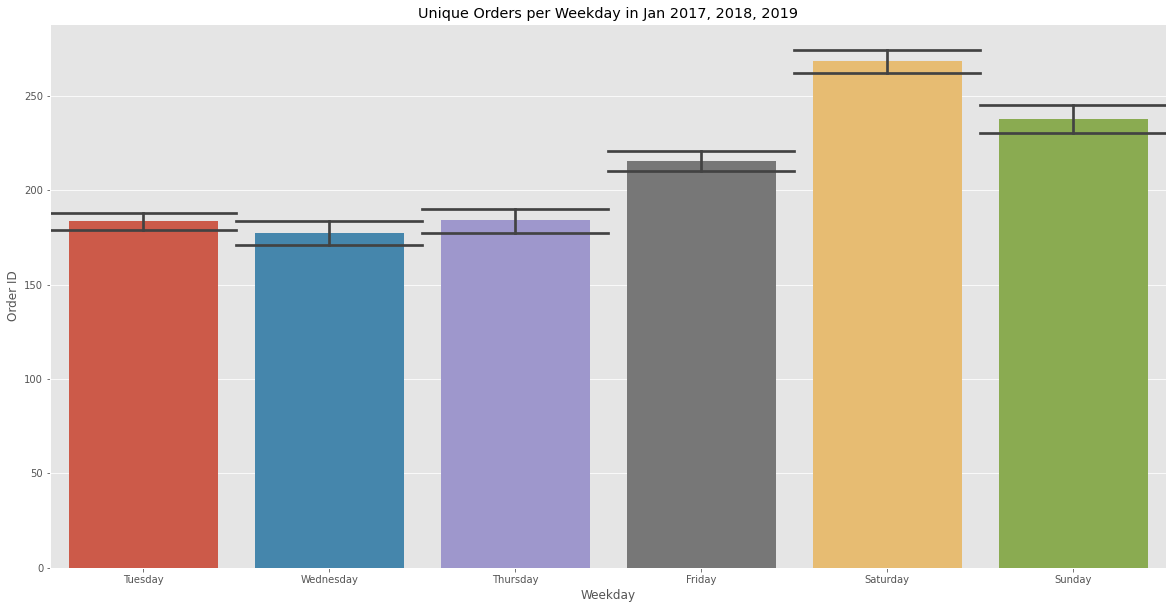

In [13]:
# look at unique order ids from previous january months

jan_sales = df.loc[(df['Month']==1)]
grouped_jan_sales = jan_sales.groupby(['Year', 'Month', 'Day of Month', 'Weekday Value', 'Weekday']).nunique().sort_values(by='Weekday Value').reset_index()

plt.title('Unique Orders per Weekday in Jan 2017, 2018, 2019')

# grouped_jan_sales
ax = sns.barplot(data=grouped_jan_sales, x='Weekday', y='Order ID', ci=95,capsize=1.0)

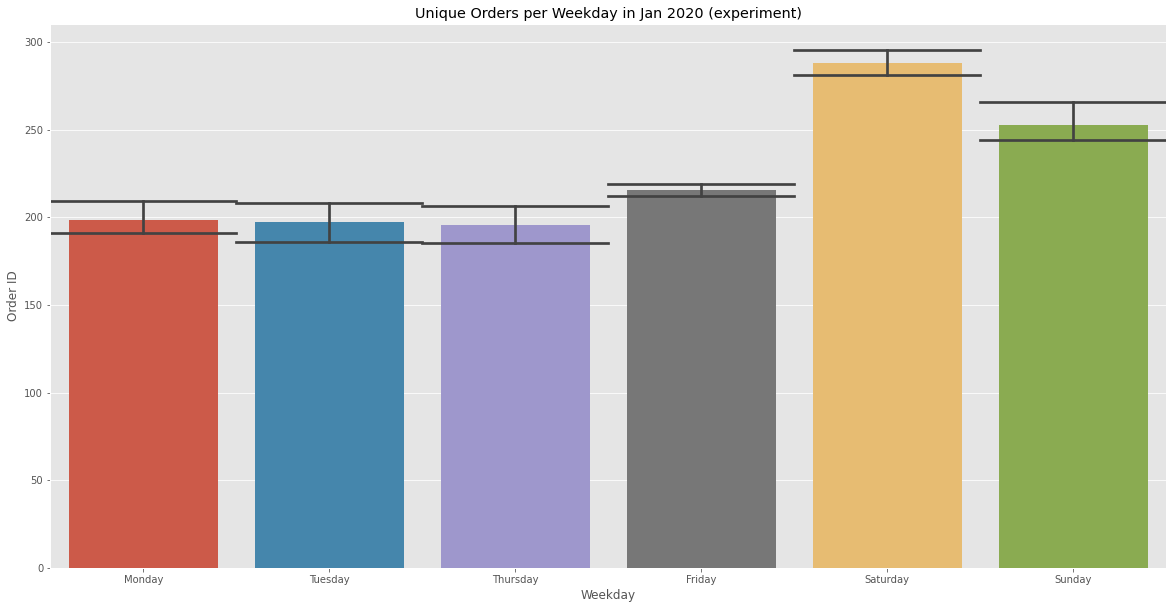

In [93]:
grouped_exp_df = exp_df.groupby(['Year', 'Month', 'Day of Month', 'Weekday Value', 'Weekday']).nunique().sort_values(by='Weekday Value').reset_index()
# grouped_exp_df

plt.title('Unique Orders per Weekday in Jan 2020 (experiment)')

ax = sns.barplot(data=grouped_exp_df, x='Weekday', y='Order ID', ci=95,capsize=1.0)  # not sure if it helps to show a confidence interval here...

# show that wednesday is missing? easiest is probably to concat a row and then sort by weekday value

##### (!) notice monday's average is higher!

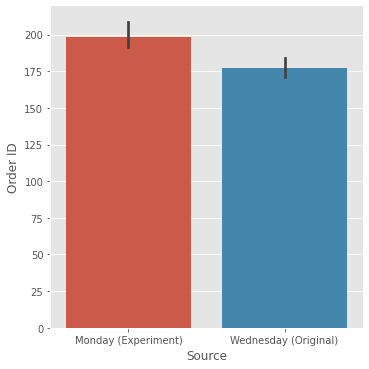

In [66]:
exp_df_monday = grouped_exp_df.loc[(grouped_exp_df['Weekday']=='Monday')]  # experiment mondays
df_jan_wednesday = grouped_jan_sales.loc[(grouped_jan_sales['Weekday']=='Wednesday')]  # non-experiment january wednesdays

exp_df_monday['Source'] = 'Monday (Experiment)'
df_jan_wednesday['Source'] = 'Wednesday (Original)'

mon_vs_wed = pd.concat([exp_df_monday, df_jan_wednesday])
mon_vs_wed

sns.catplot(data=mon_vs_wed, x='Source', y='Order ID', kind='bar');

I don't even know if the bars represent anything, but it's pretty clear that monday is higher on average...

In [94]:
# add z scores

ci = 0.05

mon_vs_wed['z_score'] = mon_vs_wed.apply(lambda x: sp.stats.zscore(mon_vs_wed['Order ID']), axis=0)
mon_vs_wed['p_value'] = mon_vs_wed.apply(lambda x: sp.stats.norm.sf(abs(mon_vs_wed['z_score'])), axis=0)

mon_vs_wed

,Year,Month,Day of Month,Weekday Value,Weekday,Order ID,Item,Quantity Ordered,Price Each,Order Date,Sales,Hour,Source,z_score,p_value
0,2020,1,27,0,Monday,193,37,6,7,160,18,8,Monday (Experiment),0.742488,0.228896
1,2020,1,6,0,Monday,215,36,6,7,171,18,8,Monday (Experiment),2.235000,0.012709
2,2020,1,20,0,Monday,190,34,6,7,154,18,8,Monday (Experiment),0.538963,0.294956
3,2020,1,13,0,Monday,195,37,6,7,157,19,8,Monday (Experiment),0.878171,0.189926
15,2017,1,25,2,Wednesday,173,35,7,6,145,18,8,Wednesday (Original),-0.614342,0.269495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,2019,1,16,2,Wednesday,193,34,6,7,157,19,8,Wednesday (Original),0.742488,0.228896
25,2017,1,11,2,Wednesday,191,35,6,7,159,17,8,Wednesday (Original),0.606805,0.271990
26,2019,1,23,2,Wednesday,177,36,6,7,147,17,8,Wednesday (Original),-0.342976,0.365808
27,2017,1,4,2,Wednesday,200,37,7,7,156,17,8,Wednesday (Original),1.217378,0.111730


it's kind of shocking that this isn't a statistically significant change. 

<!-- In this case, we're saying we're 95% certain the number of unique orders on monday will fall within that error margin.

Since it's 95% confidence interval, our z score should be 1.96?

Statistical significance tells us if something is due to chance or due to some factor of interest. If we have significance, we can feel confident that it's real (and not random luck). -->

the problem is that it's giving me sales by order. i want sales per weekday. so like 800 dollars in sales on monday or something. give me that.

# Experiment 2: A/B testing a new menu


We'll test an actual change the real restaurant made: a menu update. 

**Here's** the old menu, **here's** the new menu.



A thought on implementation: we're not actually implementing this, but if we were, we would have to carefully think this through. How will we confirm who has what menu? At first, it seems like we could just divide the restaurant in half, it's a smaller space so that might not work well. Instead, we could have a mark on the menu they used to order, and enter that as a comment when entering their order. An A or B would be fine, or you could put a sticker on the menu. As long as it works to differentiate, and you can consistently do it. 

I would expect our dataframe for the month to be the same, except there's one additional column with an A or B. 

### Menu changes

##### Starters
- Tom Kha Gai moved from starters to soup, price increased from 12 to 13
- Vegan Fresh Rolls moved from bottom of starters menu to top
- Sriracha Wings starter price increased from 10 to 11
- Chicken Satay starter price increased from 10 to 11
- Egg Rolls added to starters, price is 10
- Shrimp Rolls added to starters, price is 10

Notes: category prices went up, but not significantly. Probably okay to leave category the same or increase the quantity chance by a percent.

##### Soup
- Thai Beef Noodle Soup moved to Noodle and Fried Rice section, price increased from 12 to 13
- Tom Yum Goong price increased from 15 to 16, no longer top line item
- (reminder) Tom Kha Gai moved here from starters

##### Salad
- Nam Kao Tod price increased from 12 to 13
- Waterfall Mushroom and Tofu removed
- MyThai salad price increased from 12 to 13
- Som Tum price increased from 10 to 11
- Green Mango Salad added, price is 15

##### Barbecue
- No changes

##### Sauteed
- Pad Hi Ma Parn (Cashew Nuts), price is 15
- Pad Khing (Ginger) added, price is 15

##### Vegetables
- Pad Ma Keur (Eggplant) price increased from 12 to 15
- Pad Ram (Spinach and Mixed Vegetables) name adds "and Mixed Vegetables", price increased from 12 to 15
- Pad Pak (Mixed Vegetables) price increased from 12 to 15
- Pad Prig Khing (Green Bean) price increased from 12 to 15
- Pad Ka Nar (Broccoli) price increased from 12 to 15

##### Curries
- Green Curry price increased from 12 to 14
- Yellow Curry price increased from 12 to 14
- Red Curry price increased from 12 to 14
- Pumpkin Curry price increased from 15 to 16

##### Noodle and fried rice
- Pad Thai price increased from 12 to 13
- Pad See Ew price increased from 12 to 13
- Thai Fried Rice price increased from 12 to 13
- Pad Kee Mao price increased from 12 to 13
- Thai Streetfood Noodle price increased from 12 to 13
- Basil Fried Rice price increased from 12 to 13
- (reminder) Thai Beef Noodle Soup added from starters, price increased from 12 to 13

##### Desserts
- Sticky Rice with Mango price increased from 6 to 6.50


# Other things to test

We could test pretty much anything else we want to - the thing to be careful with is that testing is expensive (lots of time and resources, and people who can do end-to-end testing are usually pricey to hire), and could go wrong (which is the point of A/B testing - you get a 1:1 control so it's kind of like diversifying).

These tests have essentially been toy models, but if this data was real and we wanted to dig deeper, we could test this things too:
- 

Don't forget that the point of testing is to validate a belief. If you notice

# Notes

This is a super clean model where the assumption is that the restaurant has made no changes in the last three years. We can be uncharactierstically certain of our results because of this, but usually it's not so clear (and past changes aren't always so well documented).

It would be cool if we had more metrics to look at even though we're just optimizing for one. Would give us a better look into what's going on (although in a real restuarant it's easier to get qualitative data).

The way the menu test splits the room might be something we check beforehand. For the month before, just tag the orders that were where the A and B might be. It'll show us if people on one side of a room or the other are more likely to buy more. 

The new menu PDF is incorrectly uploaded (the first page is the last page). I just assumed this made no change because the restaurant can physically reorder the printed pages, but it's possible this could have an effect on online orders. 

Obviously, the data is generated, so even though we can simulate the data and measure the difference, it's not as messy as real user data. Also, the weights are mostly picked on my own biases.